# Hybrid CNN - CRF semantic segmentation

> Written by Dr Daniel Buscombe, Northern Arizona University

> Part of a series of notebooks for image recognition and classification using deep convolutional neural networks

In [1]:
%matplotlib inline

### Load libraries

In [2]:
from __future__ import division
import os, time, sys
from glob import glob
from scipy.misc import imread

#numerical
import tensorflow as tf
import numpy as np
from scipy.io import savemat, loadmat
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import create_pairwise_bilateral, unary_from_labels, unary_from_softmax
from numpy.lib.stride_tricks import as_strided as ast
import random, string

import warnings
warnings.filterwarnings("ignore")

# suppress divide and invalid warnings
np.seterr(divide='ignore')
np.seterr(invalid='ignore')

plotting libraries:

In [23]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
from scipy.misc import imresize
import matplotlib.pyplot as plt

### Define subfunctions

In [4]:
# =========================================================
def id_generator(size=6, chars=string.ascii_uppercase + string.digits):
   return ''.join(random.choice(chars) for _ in range(size))

# =========================================================
def norm_shape(shap):
   '''
   Normalize numpy array shapes so they're always expressed as a tuple,
   even for one-dimensional shapes.
   '''
   try:
      i = int(shap)
      return (i,)
   except TypeError:
      # shape was not a number
      pass

   try:
      t = tuple(shap)
      return t
   except TypeError:
      # shape was not iterable
      pass

   raise TypeError('shape must be an int, or a tuple of ints')


# =========================================================
# Return a sliding window over a in any number of dimensions
# version with no memory mapping
def sliding_window(a,ws,ss = None,flatten = True):
    '''
    Return a sliding window over a in any number of dimensions
    '''
    if None is ss:
        # ss was not provided. the windows will not overlap in any direction.
        ss = ws
    ws = norm_shape(ws)
    ss = norm_shape(ss)
    # convert ws, ss, and a.shape to numpy arrays
    ws = np.array(ws)
    ss = np.array(ss)
    shap = np.array(a.shape)
    # ensure that ws, ss, and a.shape all have the same number of dimensions
    ls = [len(shap),len(ws),len(ss)]
    if 1 != len(set(ls)):
        raise ValueError(\
        'a.shape, ws and ss must all have the same length. They were %s' % str(ls))

    # ensure that ws is smaller than a in every dimension
    if np.any(ws > shap):
        raise ValueError(\
        'ws cannot be larger than a in any dimension.\
 a.shape was %s and ws was %s' % (str(a.shape),str(ws)))
    # how many slices will there be in each dimension?
    newshape = norm_shape(((shap - ws) // ss) + 1)
    # the shape of the strided array will be the number of slices in each dimension
    # plus the shape of the window (tuple addition)
    newshape += norm_shape(ws)
    # the strides tuple will be the array's strides multiplied by step size, plus
    # the array's strides (tuple addition)
    newstrides = norm_shape(np.array(a.strides) * ss) + a.strides
    a = ast(a,shape = newshape,strides = newstrides)
    if not flatten:
        return a
    # Collapse strided so that it has one more dimension than the window.  I.e.,
    # the new array is a flat list of slices.
    meat = len(ws) if ws.shape else 0
    firstdim = (np.product(newshape[:-meat]),) if ws.shape else ()
    dim = firstdim + (newshape[-meat:])
    # remove any dimensions with size 1
    #dim = filter(lambda i : i != 1,dim)

    return a.reshape(dim), newshape

In [5]:
# =========================================================
def load_graph(model_file):
  graph = tf.Graph()
  graph_def = tf.GraphDef()

  with open(model_file, "rb") as f:
    graph_def.ParseFromString(f.read())
  with graph.as_default():
    tf.import_graph_def(graph_def)

  return graph

Below is the function that actually does the prediction

In [6]:
# =========================================================
def getCP(tmp, graph):
  
   #graph = load_graph(classifier_file)

   input_name = "import/Placeholder" #input" 
   output_name = "import/final_result" 

   input_operation = graph.get_operation_by_name(input_name);
   output_operation = graph.get_operation_by_name(output_name);

   with tf.Session(graph=graph) as sess:
      results = sess.run(output_operation.outputs[0],
                      {input_operation.outputs[0]: np.expand_dims(tmp, axis=0)})
   results = np.squeeze(results)

   # Sort to show labels of first prediction in order of confidence
   top_k = results.argsort()[-len(results):][::-1]

   return top_k[0], results[top_k[0]], results[top_k] #, np.std(tmp[:,:,0])


The image is normalized so it is less sensitive to brightness

In [99]:
# =========================================================
def norm_im(img): ##, testimage):
   input_mean = 0 #128
   input_std = 255 #128

   input_name = "file_reader"
   output_name = "normalized"
   #img = imread(image_path)
   nx, ny, nz = np.shape(img)

   theta = np.std(img).astype('int')
   #try:
   #   file_reader = tf.read_file(testimage, input_name)
   #   image_reader = tf.image.decode_jpeg(file_reader, channels = 3,
   #                                     name='jpeg_reader')
   #   float_caster = tf.cast(image_reader, tf.float32)  
   #except:
   float_caster = tf.cast(img, tf.float32)
   
   dims_expander = tf.expand_dims(float_caster, 0);
   normalized = tf.divide(tf.subtract(dims_expander, [input_mean]), [input_std])
   sess = tf.Session()
   return np.squeeze(sess.run(normalized))

The CRF function

In [8]:
# =========================================================
def getCRF(image, Lc, theta, n_iter, label_lines, compat_spat=12, compat_col=40, scale=5, prob=0.5):

#        n_iters: number of iterations of MAP inference.
#        sxy_gaussian: standard deviations for the location component
#            of the colour-independent term.
#        compat_gaussian: label compatibilities for the colour-independent
#            term (can be a number, a 1D array, or a 2D array).
#        kernel_gaussian: kernel precision matrix for the colour-independent
#            term (can take values CONST_KERNEL, DIAG_KERNEL, or FULL_KERNEL).
#        normalisation_gaussian: normalisation for the colour-independent term
#            (possible values are NO_NORMALIZATION, NORMALIZE_BEFORE, NORMALIZE_AFTER, NORMALIZE_SYMMETRIC).
#        sxy_bilateral: standard deviations for the location component of the colour-dependent term.
#        compat_bilateral: label compatibilities for the colour-dependent
#            term (can be a number, a 1D array, or a 2D array).
#        srgb_bilateral: standard deviations for the colour component
#            of the colour-dependent term.
#        kernel_bilateral: kernel precision matrix for the colour-dependent term
#            (can take values CONST_KERNEL, DIAG_KERNEL, or FULL_KERNEL).
#        normalisation_bilateral: normalisation for the colour-dependent term
#            (possible values are NO_NORMALIZATION, NORMALIZE_BEFORE, NORMALIZE_AFTER, NORMALIZE_SYMMETRIC).

      H = image.shape[0]
      W = image.shape[1]

      d = dcrf.DenseCRF2D(H, W, len(label_lines)+1)
      U = unary_from_labels(Lc.astype('int'), len(label_lines)+1, gt_prob= prob)

      d.setUnaryEnergy(U)

      del U

      # This potential penalizes small pieces of segmentation that are
      # spatially isolated -- enforces more spatially consistent segmentations
      # This adds the color-independent term, features are the locations only.
      # sxy = The scaling factors per dimension.
      d.addPairwiseGaussian(sxy=(theta,theta), compat=compat_spat, kernel=dcrf.DIAG_KERNEL, #compat=6
                      normalization=dcrf.NORMALIZE_SYMMETRIC)

      # sdims = The scaling factors per dimension.
      # schan = The scaling factors per channel in the image.
      # This creates the color-dependent features and then add them to the CRF
      feats = create_pairwise_bilateral(sdims=(theta, theta), schan=(scale, scale, scale), #11,11,11
                                  img=image, chdim=2)

      del image

      d.addPairwiseEnergy(feats, compat=compat_col, #20
                    kernel=dcrf.DIAG_KERNEL,
                    normalization=dcrf.NORMALIZE_SYMMETRIC)
      del feats

      Q = d.inference(n_iter)

      #preds = np.array(Q, dtype=np.float32).reshape(
      #  (len(label_lines)+1, nx, ny)).transpose(1, 2, 0)
      #preds = np.expand_dims(preds, 0)
      #preds = np.squeeze(preds)

      return np.argmax(Q, axis=0).reshape((H, W)) #, preds#, p, R, d.klDivergence(Q),


### Setting up the analysis

User-defined settings

In [9]:
tile = 96
winprop = 1.0
prob_thres = 0.5
n_iter = 30
compat_col = 100
theta = 60 #100
scale = 1
decim = 8
fct =  0.25 
compat_spat = 5
prob = 0.5

Labels and tensorflow graph

In [37]:
labels_path = 'ontario_labels.txt'  
classifier_file = 'ontario_test_mobilenetv2_96_100_0.01.pb' 

Next, we need to define a file that contains colors for each class in the labels file.

First, let's remind ourselves of the labels

In [16]:
!cat ontario_labels.txt

anthro
sediment
terrain
veg
water


Let's define colors in the correct order

In [17]:
cols = ['r', 'w', 'm', 'g', 'b']

In [18]:
with open('ontario_colors.txt', 'a') as the_file:
    for c in colors:
        the_file.write(c+'\n')

In [19]:
colors_path = 'ontario_colors.txt'    

In [20]:
!cat $colors_path

r
w
m
g
b


We can also use html codes for more custom colors

https://www.w3schools.com/colors/colors_picker.asp

https://www.w3schools.com/colors/colors_names.asp

In [21]:
!rm $colors_path
cols = ['#A52A2A', '#FFD700', '#808000', '#00FF7F', '#4682B4']

with open('ontario_colors.txt', 'a') as the_file:
    for c in colors:
        the_file.write(c+'\n')
        
!cat $colors_path        

#A52A2A
#FFD700
#808000
#00FF7F
#4682B4


This next part loads the labels and colors and creates a colormap for plotting

In [24]:
## Loads label file, strips off carriage return
labels = [line.rstrip() for line 
                in tf.gfile.GFile(labels_path)]

code= {}
for label in labels:
   code[label] = [i for i, x in enumerate([x.startswith(label) for x in labels]) if x].pop()

with open(colors_path) as f: #'labels.txt') as f:
   cols = f.readlines()
cmap1 = [x.strip() for x in cols] 
 
classes = dict(zip(labels, cmap1))

cmap1 = colors.ListedColormap(cmap1)

### Read file in (local)

In [77]:
testimage = 'train/201300025.JPG'
img = imread(testimage)

### Read file (S3)

In [94]:
import s3fs
fs = s3fs.S3FileSystem(anon=True)
testimage = fs.ls('cdi-workshop/semseg_data/ontario/test/')[0]
with fs.open(testimage, 'rb') as f:
    img = imread(f)

### Run analysis

Normalize image

In [96]:
nxo, nyo, nzo = np.shape(img)
result = norm_im(img)

3264


Pad image using mirroring and create tiles by using sliding window

In [97]:
## pad image so it is divisible by N windows with no remainder 
result = np.vstack((np.hstack((result,np.fliplr(result))), np.flipud(np.hstack((result,np.fliplr(result))))))
result = result[:nxo+np.mod(nxo,tile),:nyo+np.mod(nyo,tile), :] 

nx, ny, nz = np.shape(result)

gridy, gridx = np.meshgrid(np.arange(ny), np.arange(nx))
Zx,_ = sliding_window(gridx, (tile,tile), (tile,tile))
Zy,_ = sliding_window(gridy, (tile,tile), (tile,tile))

For each window, estimate the class

In [98]:
if decim>1:
   Zx = Zx[::decim]
   Zy = Zy[::decim]

print('CNN ... ')
graph = load_graph(classifier_file)

w1 = []
Z,ind = sliding_window(result, (tile,tile,3), (tile, tile,3))
if decim>1:
   Z = Z[::decim]
for i in range(len(Z)):
   w1.append(getCP(Z[i], graph))

CNN ... 


Create output arrays, filter out tiles with low probabilities

In [100]:
##C=most likely, P=prob, PP=all probs
C, P, PP = zip(*w1)

del w1

C = np.asarray(C)
P = np.asarray(P)
PP = np.asarray(PP)

C = C+1 #add 1 so all labels are >=1
PP = np.squeeze(PP)

## create images with classes and probabilities
Lc = np.zeros((nx, ny))
Lp = np.zeros((nx, ny))

mn = np.int(tile-(tile*winprop)) #tile/2 - tile/4)
mx = np.int(tile+(tile*winprop)) #tile/2 + tile/4)

for k in range(len(Zx)): 
   Lc[Zx[k][mn:mx,mn:mx], Zy[k][mn:mx,mn:mx]] = Lc[Zx[k][mn:mx,mn:mx], Zy[k][mn:mx,mn:mx]]+C[k] 
   Lp[Zx[k][mn:mx,mn:mx], Zy[k][mn:mx,mn:mx]] = Lp[Zx[k][mn:mx,mn:mx], Zy[k][mn:mx,mn:mx]]+P[k] 

Lpp = np.zeros((nx, ny, np.shape(PP)[1]))
for k in range(len(Zx)): 
   for l in range(np.shape(PP)[1]):
      Lpp[Zx[k], Zy[k], l] = Lpp[Zx[k], Zy[k], l]+PP[k][l]

Lpp = Lpp[:nxo, :nyo, :]      
Lp = Lp[:nxo, :nyo]      
Lc = Lc[:nxo, :nyo]


In [101]:
Lcorig = Lc.copy()
Lcorig[Lp < prob_thres] = np.nan

Lc[np.isnan(Lcorig)] = 0

We're going to resize to speed things up a little

In [105]:
imgr = imresize(img, fct)
Lcr = np.round(imresize(Lc, fct, interp='nearest')/255 * np.max(Lc))

In [108]:
np.shape(imgr)

(816, 1088, 3)

In [109]:
np.shape(Lcr)

(816, 1088)

Conditional Random Field post-processing

In [110]:
print('CRF ... ')
res = getCRF(imgr, Lcr.astype('int'), theta, n_iter, labels, compat_spat, compat_col, scale, prob)

del imgr
resr = np.round(imresize(res, 1/fct, interp='nearest')/255 * np.max(res))
   
code1 = np.unique(res)
code2 = np.unique(resr)   
resrr = np.zeros(np.shape(resr), dtype='int8')
for kk in range(len(code1)):
   resrr[resr==code2[kk]] = code1[kk]   
   
del res, resr

CRF ... 


### Plot Result

Lastly, we can plot the result

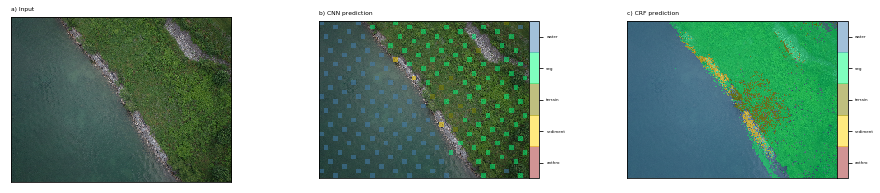

In [116]:
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(wspace=0.4)
ax1 = fig.add_subplot(131)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

im = ax1.imshow(img)
plt.title('a) Input', loc='left', fontsize=6)

ax1 = fig.add_subplot(132)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

im = ax1.imshow(img)
plt.title('b) CNN prediction', loc='left', fontsize=6)
im2 = ax1.imshow(Lcorig-1, cmap=cmap1, alpha=0.5, vmin=0, vmax=len(labels))
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%")
cb=plt.colorbar(im2, cax=cax)
cb.set_ticks(.5+np.arange(len(labels)+1)) 
cb.ax.set_yticklabels(labels)
cb.ax.tick_params(labelsize=4) 
plt.axis('tight')

ax1 = fig.add_subplot(133)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

im = ax1.imshow(img)
plt.title('c) CRF prediction', loc='left', fontsize=6)
im2 = ax1.imshow(resrr, cmap=cmap1, alpha=0.5, vmin=0, vmax=len(labels))
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%")
cb=plt.colorbar(im2, cax=cax)
cb.set_ticks(.5+np.arange(len(labels)+1)) 
cb.ax.set_yticklabels(labels)
cb.ax.tick_params(labelsize=4)  